In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import Tensor

import numpy as np
import matplotlib.pyplot as plt

# Example Sequence

[False, True, True, False]
[True, True, False, True]
[False, False, True, False]
[True, False, True, True]
[False, True, True, True]
[True, True, False, False]
[False, False, True, True]
[True, False, True, True]
[False, True, True, True]
[True, True, False, False]
[False, False, True, True]
[True, False, True, True]
[False, True, True, True]
[True, True, False, False]
[False, False, True, True]
[True, False, True, True]
[False, True, True, True]
[True, True, False, False]
[False, False, True, True]
[True, False, True, True]
[False, True, True, True]


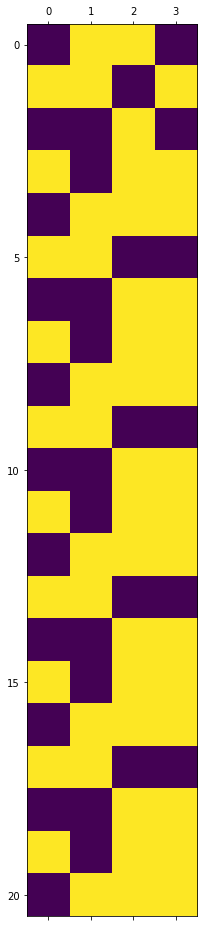

In [4]:
seq = [[False, True, True, False]]
print(seq[0])

for i in range(20):
    last = seq[i]
    new = [
        not(last[0]),
        last[0] != last[1],
        last[2] != last[1],
        not(last[3]) & last[1],
    ]
    
    print(new)
    seq.append(new)
plt.matshow(seq)

# Define Network

In [5]:
class NetworkLSTM(nn.Module):
    
    input_size = 1
    output_size = 4;
    hidden_size = 4;
    num_layers=4;
    
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            bias=True,
            batch_first=False,
            dropout=1,
            bidirectional=False
        )
        
        
    def forward(self, x, hc):
        output , (h, c) = self.lstm(x, hc)
        output = nn.functional.sigmoid(output)
        return output, (h, c)
    
    def getInitialStates(self):
        c0 = Variable(torch.zeros(self.num_layers,1, self.hidden_size))
        h0 = Variable(torch.zeros(self.num_layers,1, self.hidden_size))
        return (h0, c0)
    
class NetworkRNN(nn.Module):
    
    input_size = 4
    output_size = 4;
    hidden_size = 10;
    num_layers=1;
    
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=0.1,
        )
        
        self.Linear = nn.Linear(
            in_features=self.hidden_size,
            out_features=self.output_size,
            bias=True
        )
        
        
    def forward(self, x, h):
        output , h = self.rnn(x, h)
        output = nn.functional.sigmoid(output)
        output = self.Linear(output)
        output = nn.functional.sigmoid(output)
        return output, h
    
    def getInitialStates(self):
        h0 = Variable(torch.zeros(self.num_layers,1, self.hidden_size))
        return h0

Network = NetworkRNN

net = Network()
state= net.getInitialStates()
input = Tensor(torch.zeros(1,1,4))
net(input, state)

c:\users\pol\.virtualenvs\bartokifier-x6rjhkm6\lib\site-packages\torch\nn\modules\rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\users\pol\.virtualenvs\bartokifier-x6rjhkm6\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(tensor([[[0.4207, 0.5008, 0.4352, 0.4903]]], grad_fn=<SigmoidBackward>),
 tensor([[[ 0.0580, -0.0366, -0.1086, -0.0256, -0.1977,  0.3445, -0.0772,
           -0.1354, -0.1754,  0.0919]]], grad_fn=<StackBackward>))

# Net without training

In [6]:
net = Network()

state = net.getInitialStates()
for x in range(20):
    input = Tensor(torch.zeros(1,1,4))
    output, state = net(input, state)
    print(output)

tensor([[[0.3824, 0.3953, 0.5214, 0.4085]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3781, 0.3977, 0.5211, 0.4057]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3744, 0.3950, 0.5190, 0.4053]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3749, 0.3953, 0.5197, 0.4042]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3744, 0.3962, 0.5192, 0.4033]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3749, 0.3965, 0.5192, 0.4032]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3752, 0.3965, 0.5195, 0.4032]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3753, 0.3966, 0.5196, 0.4033]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3754, 0.3965, 0.5197, 0.4033]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3754, 0.3965, 0.5197, 0.4034]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3753, 0.3965, 0.5197, 0.4034]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3753, 0.3965, 0.5197, 0.4034]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3753, 0.3965, 0.5197, 0.4034]]], grad_fn=<SigmoidBackward>)
tensor([[[0.3753, 0.3965, 0.5197, 0.4034]]], grad_fn=<SigmoidBac

# Training

In [7]:
net = Network()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)

losses = [];

for epoch in range(240):
    state = net.getInitialStates()
    total_loss = 0;
    input = torch.rand(1,1,4)
    for i,timestep in enumerate(seq):
        timestep = Tensor(timestep)
        output, state = net(input, state)
        loss = criterion(output, timestep)
        input=timestep.view(1,1,4)
        loss.backward(retain_graph=True)
        total_loss += loss;
        losses.append(total_loss)
        optimizer.step()
        optimizer.zero_grad()


c:\users\pol\.virtualenvs\bartokifier-x6rjhkm6\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([1, 1, 4])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [8]:
print(timestep.view(1,1,4))
print(input)

tensor([[[0., 1., 1., 1.]]])
tensor([[[0., 1., 1., 1.]]])


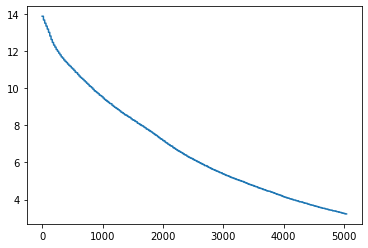

In [9]:
plt.plot(losses)

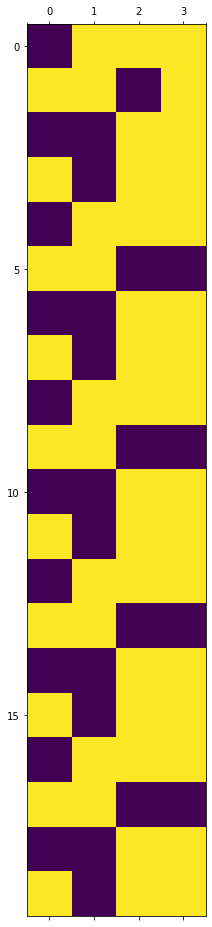

In [10]:
predseq = []
state = net.getInitialStates()
input = torch.rand(1,1,4)
for x in range(20):
    
    output, state = net(input, state)
    input=output.view(1,1,4)
    next = np.asarray([output > 0.5][0])[0][0]
    predseq.append(next)
        
plt.matshow(predseq)